# Model Selection

In the last exercise section, we have seen how to manage the bias-variance trade-off and how to properly evaluate our model for a given task. In this exercise section, we will see some of the methods to select a model in the first place. These includes:

- feature selection, which is a supervised methodology to identify the relevant features for a given task;

- principal component analysis for dimensionality reduction, which is an unsupervised methodology to reduce the dataset dimensionality;

- regularization with the $k$ paramater in the $k$-nearest neighbours classifier.

## Feature Selection

Let us suppose to face a common classification task on the Iris Dataset, e.g., we would like to train a model to classify 'Iris-virginica' against 'Non-virginica'.

First, we can load the dataset, which is provided by sklearn

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

# the variable iris now contains inputs ('data' field), targets ('target', field) 
# and other stuff. Let us keep the inputs and targets in two separate variables

X = iris.data
y = iris.target

The standard targets are suited for a 3-class classification, where the class 0 is 'Setosa', 1 is 'Versicolor', 2 is 'Virginica'. Let us rearrange the target $y$ to have just class 1 for 'Virginica', 0 for 'Non-virginica'

In [ ]:
print('Original targets\n', y)

# the dataset is stored in the variable iris
y = iris.target.copy()
# 0 - setosa, 1 - versicolor, 2 - virginica
y[y == 1] = 0
y[y == 2] = 1

print('Iris-Virginica targets\n', y)

As it is well-known, this dataset has four input features. But how many of them are actually relevant for our classification task?

### Backward Feature Selection

Let us try to identify a convenient subset of $k$ features for our classification task. In principle, we would have to train $\binom{4}{k}$ models, one for each $k \in \{ 1,2,3,4 \}$, and to compare one model against the others. This sounds quite inefficient. Instead, we start from the complete set of features and we try to iteratively remove the least relevant feature.

But first, do not forget to split the data in train/test/validation sets (here we will use validation to make a decision on the subset of features).

In [ ]:
import numpy as np
# set the seed to get consistent splits
np.random.seed(0)

# let us concatenate X and y in a single matrix 
D = np.concatenate((X, y.reshape(len(y), -1)), axis=1)

# then we shuffle D
np.random.shuffle(D)

# and we slip the data as 50/20/20
X_train = D[:90,:4]
y_train = D[:90,4]
X_vali = D[90:120,:4]
y_vali = D[90:120,4]
X_test = D[120:150,:4]
y_test = D[120:150,4]

Let us train the full model (e.g., logistic regression) at first.

In [ ]:
from sklearn.linear_model import LogisticRegression

# logistic regression on the original dataset
log_classifier = LogisticRegression(penalty='none') # regularization is applied as default
log_classifier.fit(X_train, y_train)
y_hat_vali = log_classifier.predict(X_vali)
vali_accuracy = sum(y_hat_vali == y_vali) / len(y_vali)
print('Validation accuracy:', vali_accuracy)

Validation accuracy: 1.0


The task is quite simple, and the full model is perfect on the validation set. But all the features are necessary here?

Let us train a model $M_{-i}$ which consider the set of features $\{ x_0, x_1, x_2, x_3 \} \setminus \{ x_i \}$ for each $i \in \{ 0, 1, 2, 3\}$

In [ ]:
# full set of features
F = [0, 1, 2, 3]

for i in range(len(F)):
  # remove the feature i from train and validation
  X_train_i = np.delete(X_train, i, axis=1)
  X_vali_i = np.delete(X_vali, i, axis=1)
  # fit the classifier
  log_classifier_i = LogisticRegression(penalty='none') # regularization is applied as default
  log_classifier_i.fit(X_train_i, y_train)
  # evaluate on validation
  y_hat_vali = log_classifier_i.predict(X_vali_i)
  vali_accuracy = sum(y_hat_vali == y_vali) / len(y_vali)
  print('The model with features', F, 'without', F[i], 'has validation accuracy:', vali_accuracy)

The model with features [0, 1, 2, 3] without 0 has validation accuracy: 1.0
The model with features [0, 1, 2, 3] without 1 has validation accuracy: 1.0
The model with features [0, 1, 2, 3] without 2 has validation accuracy: 1.0
The model with features [0, 1, 2, 3] without 3 has validation accuracy: 1.0


As you can see, removing one feature does not seem to impact the performance. Let us remove a feature randomly (e.g., $x_0$), so that we can repeat the process with three features

F = [1, 2, 3]
X_train_new = X_train[:, F]
X_vali_new = X_vali[:, F]
for i in range(len(F)):
  # remove the feature from train and validation
  X_train_i = np.delete(X_train_new, i, axis=1)
  X_vali_i = np.delete(X_vali_new, i, axis=1)
  # fit the classifier
  log_classifier_i = LogisticRegression(penalty='none') # regularization is applied as default
  log_classifier_i.fit(X_train_i, y_train)
  # evaluate on validation
  y_hat_vali = log_classifier_i.predict(X_vali_i)
  vali_accuracy = sum(y_hat_vali == y_vali) / len(y_vali)
  print('The model with features', F, 'without', F[i], 'has validation accuracy:', vali_accuracy)

Removing feature $x_1$ we are still perfect on the validation accuracy, thus, we can remove $x_1$ without any drop in the (estimated) performance

In [ ]:
F = [2, 3]
X_train_new = X_train[:,F]
X_vali_new = X_vali[:, F]
for i in range(len(F)):
  # remove the feature from train and validation
  X_train_i = np.delete(X_train_new, i, axis=1)
  X_vali_i = np.delete(X_vali_new, i, axis=1)
  # fit the classifier
  log_classifier_i = LogisticRegression(penalty='none') # regularization is applied as default
  log_classifier_i.fit(X_train_i, y_train)
  # evaluate on validation
  y_hat_vali = log_classifier_i.predict(X_vali_i)
  vali_accuracy = sum(y_hat_vali == y_vali) / len(y_vali)
  print('The model with features', F, 'without', F[i], 'has validation accuracy:', vali_accuracy)

The model with features [2, 3] without 2 has validation accuracy: 0.9666666666666667
The model with features [2, 3] without 3 has validation accuracy: 0.9666666666666667


Removing another feature from $\{ x_2, x_3 \}$ seems to reduce the performance in any case. Thus, we can stop here the backward feature selection procedure and keep only $\{ x_2, x_3 \}$ in the final dataset. 
Going from a four features to two might seem a minor feat, but this is a very small example, and we are still halving the dimensionality of the dataset. The final model is also simpler, i.e., less prone to overfitting.

Until now we have evaluated the feature selection with the validation set, let us look how the model behave on the test set

In [ ]:
# we can merge back the validation into the train set
X_train = np.concatenate((X_train, X_vali))
y_train = np.concatenate((y_train, y_vali))

# and extract the dataset after feature selection
F = [2, 3]
X_train_fs = X_train[:, F]
X_test_fs = X_test[:, F]

# we fit the model once again on the new training
log_classifier_fs = LogisticRegression(penalty='none')
log_classifier_fs.fit(X_train_fs, y_train)
# and we evaluate it on the test set
y_hat_test = log_classifier_fs.predict(X_test_fs)
test_accuracy = sum(y_hat_test == y_test) / len(y_test)
print('The model with feature', F, 'has test accuracy:', test_accuracy)

The model with feature [2, 3] has test accuracy: 0.9333333333333333


Now that the dataset has only two features it is also easier to visualize

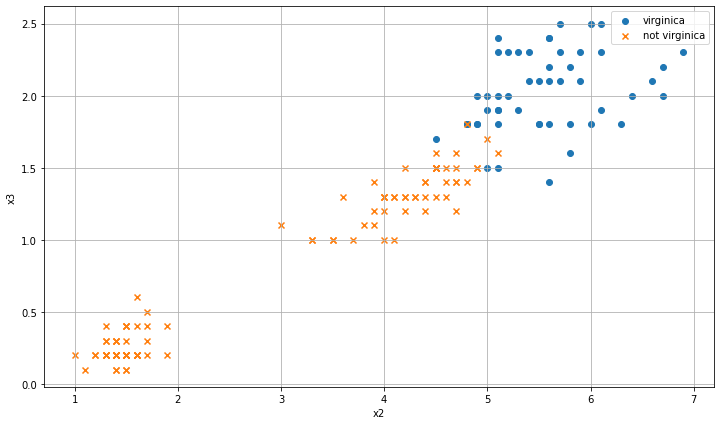

In [ ]:
from matplotlib import pyplot as plt

virginica = X[y == 1]
not_virginica = X[y == 0]

plt.figure(figsize=(12,7))
plt.scatter(virginica[:, 2], virginica[:, 3], label='virginica')
plt.scatter(not_virginica[:, 2], not_virginica[:, 3], label='not virginica', marker='x')

plt.xlabel('x2')
plt.ylabel('x3')
plt.grid()
plt.legend()
plt.show()

We can also plot the discriminative surface of the perceptron

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


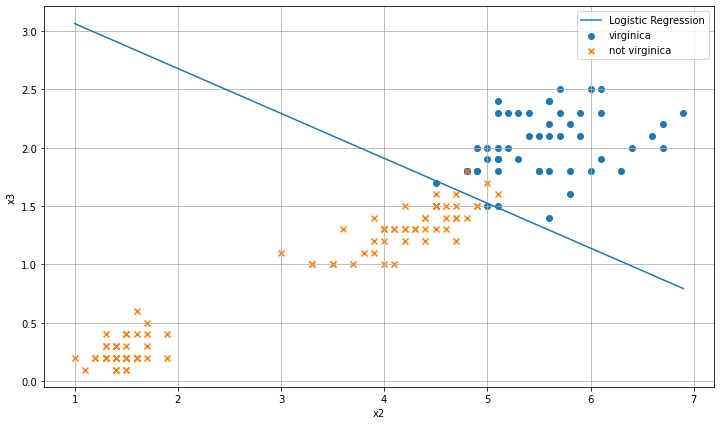

In [ ]:
# Same function of Exercise Session 2
def plot_ds(X, w, step=100, label='DS'):
  ds_x1 = np.linspace(X[:,2].min(), X[:,2].max(), step) 
  ds_x2 = [-(w[0] + w[1]*x1) / w[2] for x1 in ds_x1]
  plt.plot(ds_x1, ds_x2, label=label)

plt.figure(figsize=(12,7))
coef = log_classifier_fs.coef_.flatten() # weights 
w0 = log_classifier_fs.intercept_ # bias
log_w = np.array([w0, coef[0], coef[1]])
plot_ds(X, log_w, label='Logistic Regression')

plt.scatter(virginica[:, 2], virginica[:, 3], label='virginica')
plt.scatter(not_virginica[:, 2], not_virginica[:, 3], label='not virginica', marker='x')

plt.xlabel('x2')
plt.ylabel('x3')
plt.grid()
plt.legend()
plt.show()

## Dimensionality Reduction: Principal Component Analysis

Principal Component Analysis (PCA) is an unsupervised technique to perform dimensionality reduction, i.e., to extract some low dimensional features from a dataset. Especially, we aim to find a linear transformation of the original data X s.t. the largest variance lies on the first transformed feature, the second largest variance on the second transformed feature and so on. At last, we only keep some of the features we extracted.

To see how to perform PCA in practice, let us start once again from the Iris Dataset

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

# the variable iris now contains inputs ('data' field), targets ('target', field) 
# and other stuff. Let us keep the inputs and targets in two separate variables

X = iris.data
y = iris.target

# Note: PCA is an unsupervised technique, so we do not need y actually

To identify the principal components (i.e., the extracted features), we have to:
 
1. Normalize the original inputs X to obtain a matrix ($\tilde{X}$) with zero (column-wise) mean;
2. Compute the covariance matrix of $\tilde{X}$, i.e., $C = \tilde{X}^\top \tilde{X}$;
3. Compute the eigenvectors $e$ and eigenvalues $\lambda$ of $C$:
  
  - The eigenvector $e_1$ corresponding to the largest eigenvalue $\lambda_1$ will be the first principal component direction;

  - The eigenvector $e_2$ corresponding to the largest eigenvalue $\lambda_2$ will be the second principal component direction;

  - ...


Let us center the data in X (step 1)

In [ ]:
import numpy as np

X_tilde = X - np.mean(X, axis=0)

# Note: np.mean(X, axis=0) returns a vector containing the mean of each column
np.mean(X, axis=0)

array([5.84333333, 3.05733333, 3.758     , 1.19933333])

We now compute the covariance matrix $C$ (step 2)

In [ ]:
C = np.dot(X_tilde.T, X_tilde)

print(C)

[[102.16833333  -6.32266667 189.873       76.92433333]
 [ -6.32266667  28.30693333 -49.1188     -18.12426667]
 [189.873      -49.1188     464.3254     193.0458    ]
 [ 76.92433333 -18.12426667 193.0458      86.56993333]]


We extract the eigenvectors and eigenvalues of $C$ with the eig function of numpy (https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(C)

print('eigenvalues:\n', eigenvalues)
print('eigenvectors:\n', eigenvectors)

# Note: each column of eigenvectors is the unit-length eigenvector corresponding to the i-th eigenvalue in eigenvalues

eigenvalues:
 [630.0080142   36.15794144  11.65321551   3.55142885]
eigenvectors:
 [[ 0.36138659 -0.65658877 -0.58202985  0.31548719]
 [-0.08452251 -0.73016143  0.59791083 -0.3197231 ]
 [ 0.85667061  0.17337266  0.07623608 -0.47983899]
 [ 0.3582892   0.07548102  0.54583143  0.75365743]]


The columns of the eigenvectors matrix identify the directions of the principal components. Thus, we have obtained the linear transformation matrix ($W$) we were looking for, and we can now transform the data as $T = \tilde{X} W$

In [ ]:
W = eigenvectors

T = np.dot(X_tilde, W)

print('Original data point:', X[21])
print('Transformed data point:', T[21])

Original data point: [5.1 3.7 1.5 0.4]
Transformed data point: [-2.54370523 -0.43299606  0.20845723  0.0410654 ]


### PCA with Scikit Learn

Notably, there exist a much easier strategy to obtain the same linear transformation: use the scikit learn implementation (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [ ]:
from sklearn.decomposition import PCA

# we create a PCA object
pca = PCA()

# we fit the dataset in X
pca.fit(X)

# we extract the principal components directions
print('first principal component direction:', pca.components_[:,0])

# and the corresponding explained variance
explained = pca.explained_variance_
print('explained variance:', explained)

first principal component direction: [ 0.36138659  0.65658877 -0.58202985 -0.31548719]
explained variance: [4.22824171 0.24267075 0.0782095  0.02383509]


Finally, we can transoform the data as $T = \tilde{X} W$

In [ ]:
T = pca.transform(X)

print('The same data point as before:', T[21])

The same data point as before: [-2.54370523  0.43299606  0.20845723 -0.0410654 ]


### From Linear Transformation to Dimensionality Reduction

Until now, we have simply transoformed the dataset, but we didn't reduce its dimensions. To perform dimensionality reduction, we can keep just the first $k$ columns of the linear transformation matrix $W$ (i.e., the first $k$ new axes) instead of all of them.

But how can we choose $k$ properly? There exist several different strategies, such as:
- Keep all the principal components until we cumulate at least 90% (or 95%) of the variance;
- Keep all the principal components which explain more of the 5% of the variance;
- Find the elbow in the cumulated variance.


E.g., let us look for the elbow of the explained variance (as a function of the number of components)

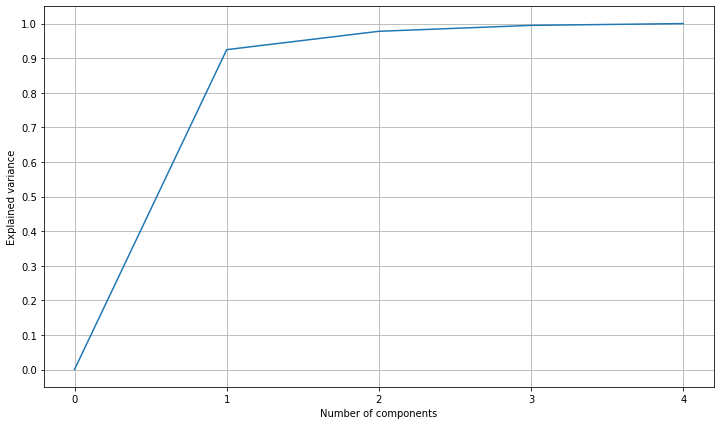

In [ ]:
from matplotlib import pyplot as plt

explained_variance = np.cumsum(explained) / sum(explained)
explained_variance = np.insert(explained_variance, 0, 0.)

plt.figure(figsize=(12,7))
plt.plot(range(5), explained_variance)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.xticks(range(5))
plt.yticks(np.arange(0., 1.1, 0.1))
plt.grid()
plt.show()

In [ ]:
explained_variance = np.cumsum(explained) / sum(explained)
explained_variance < 0.98
X_tilde = X[:, explained_variance < 0.98]
X_tilde

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6],
       [5.4, 3.9],
       [4.6, 3.4],
       [5. , 3.4],
       [4.4, 2.9],
       [4.9, 3.1],
       [5.4, 3.7],
       [4.8, 3.4],
       [4.8, 3. ],
       [4.3, 3. ],
       [5.8, 4. ],
       [5.7, 4.4],
       [5.4, 3.9],
       [5.1, 3.5],
       [5.7, 3.8],
       [5.1, 3.8],
       [5.4, 3.4],
       [5.1, 3.7],
       [4.6, 3.6],
       [5.1, 3.3],
       [4.8, 3.4],
       [5. , 3. ],
       [5. , 3.4],
       [5.2, 3.5],
       [5.2, 3.4],
       [4.7, 3.2],
       [4.8, 3.1],
       [5.4, 3.4],
       [5.2, 4.1],
       [5.5, 4.2],
       [4.9, 3.1],
       [5. , 3.2],
       [5.5, 3.5],
       [4.9, 3.6],
       [4.4, 3. ],
       [5.1, 3.4],
       [5. , 3.5],
       [4.5, 2.3],
       [4.4, 3.2],
       [5. , 3.5],
       [5.1, 3.8],
       [4.8, 3. ],
       [5.1, 3.8],
       [4.6, 3.2],
       [5.3, 3.7],
       [5. , 3.3],
       [7. , 3.2],
       [6.4, 3.2],
       [6.9,

We can see that the first two principal components dimensions accounts for the largest share of the explained variance (around 98%). Thus we may choose $k = 2$ to obtain the new dataset $T_2 = \tilde{X} W_{1,2}$, where $W_{1,2}$ is obtained from $W$ keeping the first two columns.

In [ ]:
# without Scikit Learn
T_12 = np.dot(X_tilde, W[:,:2])

print('Data point with reduced dimensionality', T_12[21])

Data point with reduced dimensionality [-2.54370523 -0.43299606]


In [ ]:
# with Scikit Learn
pca2 = PCA(n_components=2)
T_12 = pca2.fit_transform(X)

print('Data point with reduced dimensionality', T_12[21])

Data point with reduced dimensionality [-2.54370523  0.43299606]


### PCA for Classification

There are multiple purposes to perform the PCA and project the dataset into a lower dimensional space. At first, we could consider the principal components analysis as a feature extraction technique for classification and regression tasks.

Let us get back to the 'Iris-Setosa' classification task. First, we recover the corresponding targets from the dataset.

In [ ]:
# the dataset is stored in the variable iris
y = iris.target.copy()
# 0 - setosa, 1 - versicolor, 2 - virginica
y[y == 1] = 2
y[y == 0] = 1
y[y == 2] = 0

print('Iris-Setosa targets\n', y)

Iris-Setosa targets
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


Let us consider a logistic regression trained over different input dataset, i.e.
, the original one ($X$), the first two principal components ($T_{1,2}$) and the last two ($T_{3,4}$).

In [ ]:
from sklearn.linear_model import LogisticRegression

# logistic regression on the original dataset
log_classifier_original = LogisticRegression(penalty='none') # regularization is applied as default
log_classifier_original.fit(X, y)
y_hat_original = log_classifier_original.predict(X)
acc_original = sum(y_hat_original == y) / len(y)
print('Accuracy original:', acc_original)

# logistic regression on the first two pc
T_12 = np.dot(X_tilde, W[:,:2])
log_classifier_12 = LogisticRegression(penalty='none')
log_classifier_12.fit(T_12, y)
y_hat_12 = log_classifier_12.predict(T_12)
acc_12 = sum(y_hat_12 == y) / len(y)
print('Accuracy first two pc:', acc_12)

# logiastic regression on the last two pc
T_34 = np.dot(X_tilde, W[:,2:])
log_classifier_34 = LogisticRegression(penalty='none')
log_classifier_34.fit(T_34, y)
y_hat_34 = log_classifier_34.predict(T_34)
acc_34 = sum(y_hat_34 == y) / len(y)
print('Accuracy last two pc:', acc_34)

Accuracy original: 1.0
Accuracy first two pc: 1.0
Accuracy last two pc: 0.6666666666666666


As you can see, the use of the first two principal components gives similar results, since they accounts for around 98% of the variance of the original data. Instead, it makes little sense to use the last two principal components (which explain a small share of the variance) and the corresponding accuracy drops significantly.

Indeed, let us visualize the data in the space defined by the first two principal components as opposed to the last two

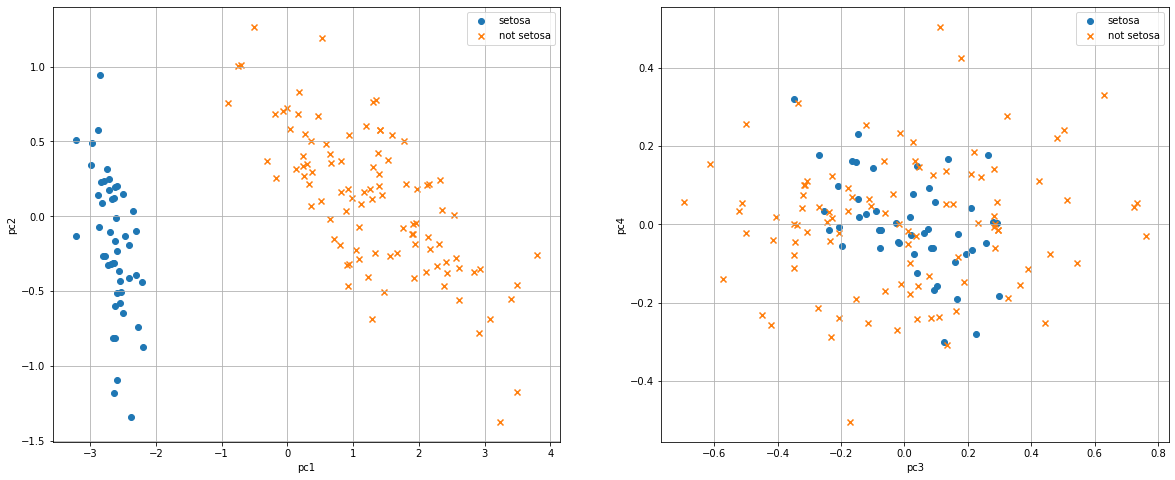

In [ ]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

setosa = T_12[y == 1]
not_setosa = T_12[y == 0]

ax1.scatter(setosa[:, 0], setosa[:, 1], label='setosa')
ax1.scatter(not_setosa[:, 0], not_setosa[:, 1], label='not setosa', marker='x')
ax1.set(xlabel='pc1', ylabel='pc2')
ax1.grid()
ax1.legend()

setosa = T_34[y == 1]
not_setosa = T_34[y == 0]

ax2.scatter(setosa[:, 0], setosa[:, 1], label='setosa')
ax2.scatter(not_setosa[:, 0], not_setosa[:, 1], label='not setosa', marker='x')
ax2.set(xlabel='pc3', ylabel='pc4')
ax2.grid()
ax2.legend()

plt.show()

As a final remark we should underline that the PCA does not make use of the label when is performed on a dataset, while other model selection techniques are based on the a posteriori performance of the classifier (e.g., feature selection).

## Regularization

We have already seen regularization techniques in relation with linear regression (e.g., Lasso, Ridge regression). This is actually a model selection technique, as it allows to tune the model complexity through a hyper-paramter (commonly denoted as $\lambda$ in linear regression)

Let us now consider the regularization technique in a different context, i.e., a classification task with the k-Nearest Neighbors (k-NN) classifier. k-NN is a non-parametric method that coarsely works as follows: Suppose you have to predict the class of a new data point, look at the $k$ data points in the train set that are the closest to this new one, and decides the class of it accordingly (usually via majority voting).

As it is common in non-parametric methods, the k-NN classifier does not involve a real training phase, it just has to keep in memory the train set to make predictions. However, we need to properly choose the hyper-parameter $k$ beforehand, which is actually a regularization parameter.

Let us look at how this works in practice on a classification task

As usual, we first load the Iris Dataset

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

# the variable iris now contains inputs ('data' field), targets ('target', field) 
# and other stuff. Let us keep the inputs and targets in two separate variables

X = iris.data
y = iris.target

print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In this case, we would like to learn a classifier to discriminate between 'versicolor' and 'not-versicolor' by looking at the speal length and width. To do so, we split the data in a train set and a test set

In [ ]:
import numpy as np
# set the seed to get consistent splits
np.random.seed(0)

# we update the targets according to our preferred task
# 0 - setosa, 1 - versicolor, 2 - virginica
y[y == 2] = 0

# let us concatenate X and y in a single matrix 
D = np.concatenate((X[:, :2], y.reshape(len(y), -1)), axis=1)

# then we shuffle D
np.random.shuffle(D)

# and we slip the data as 50/20/20
X_train = D[:100,:2]
y_train = D[:100,2]
X_test = D[100:150,:2]
y_test = D[100:150,2]

Let us plot the train data on the 2D sepal-length/sepal-width space

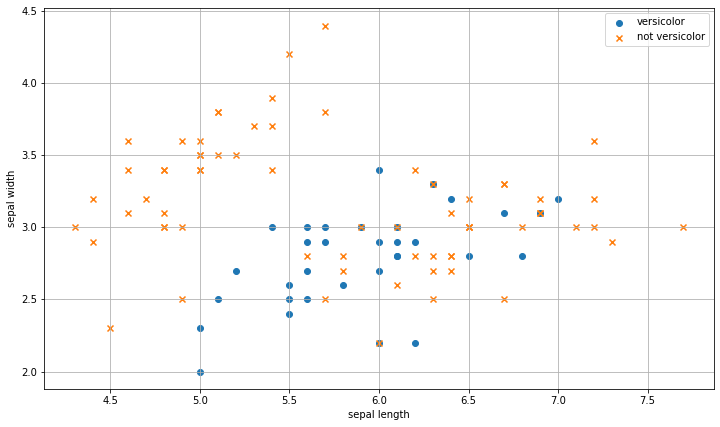

In [ ]:
from matplotlib import pyplot as plt

versicolor = X_train[y_train == 1]
not_versicolor = X_train[y_train == 0]

plt.figure(figsize=(12,7))
plt.scatter(versicolor[:, 0], versicolor[:, 1], label='versicolor')
plt.scatter(not_versicolor[:, 0], not_versicolor[:, 1], label='not versicolor', marker='x')

plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.grid()
plt.legend()
plt.show()

The task looks quite hard, as data are not linearly separable. Let us fit a familiy of k-NN with different values for k, e.g., $k \in \{1, \ldots, 10\}$. For each classifier, we plot the corresponding decision surface with the function below

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# function to plot the decision surface of the k-NN classifier,
# see https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

def knn_decision_surface(X, y, clf, k):

  # let us prepare the decision surface by calling the predict over a grid of points
  h = .02
  x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
  y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2 
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  # colormap for the contour plot
  cmap_light = ListedColormap(['orange', 'cornflowerblue'])

  # plotting functions
  plt.figure(figsize=(12, 7))
  plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
  plt.scatter(versicolor[:, 0], versicolor[:, 1], label='versicolor')
  plt.scatter(not_versicolor[:, 0], not_versicolor[:, 1], label='not versicolor', marker='x')
  plt.xlabel('sepal length')
  plt.ylabel('sepal width')
  plt.title("k = {}".format(k))
  plt.show()

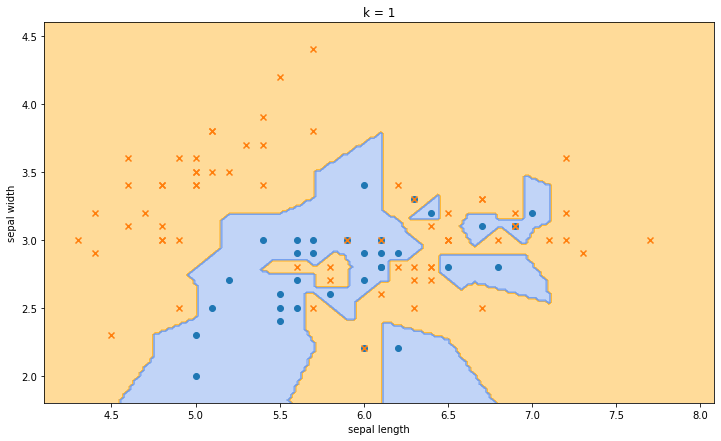

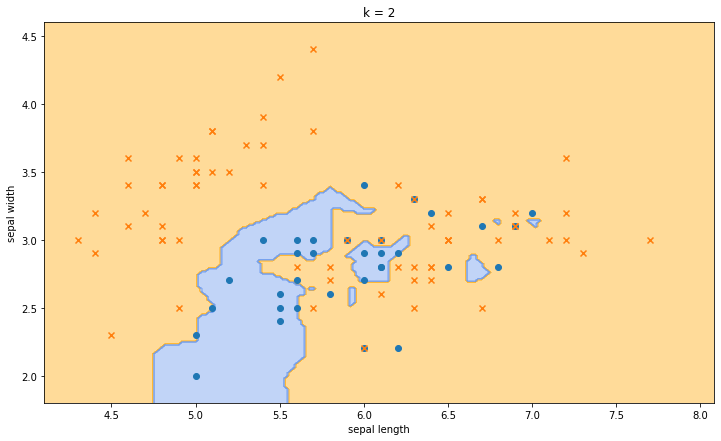

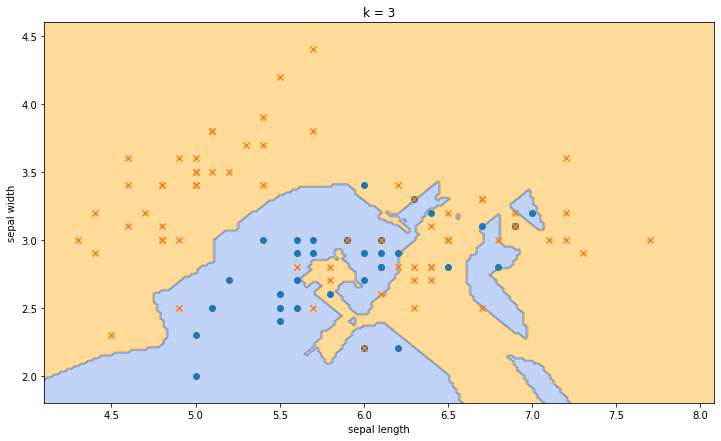

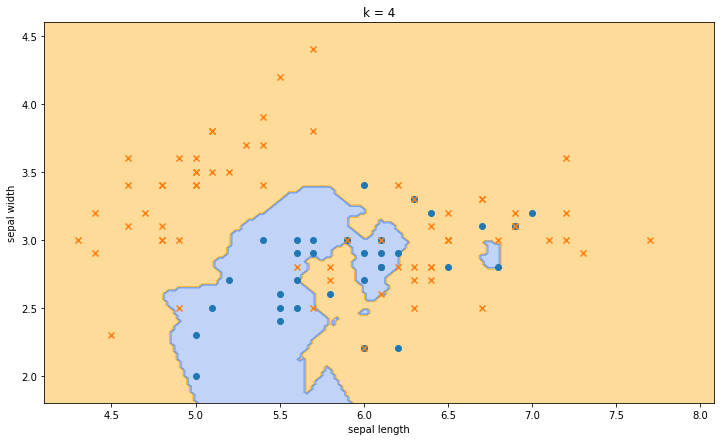

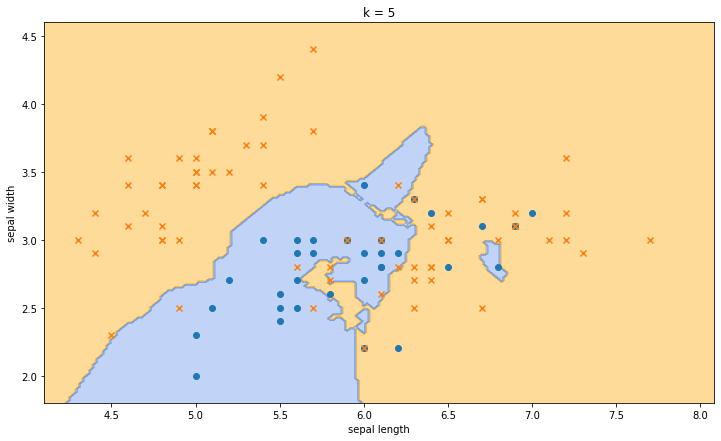

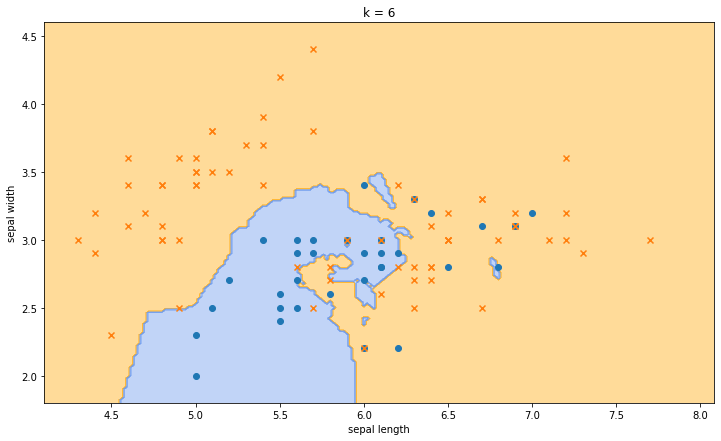

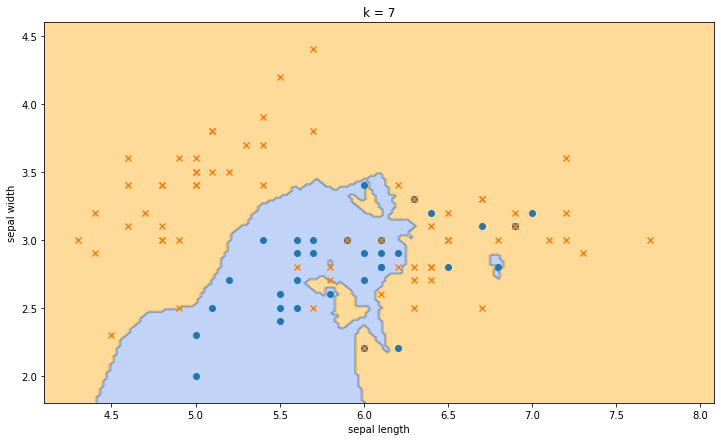

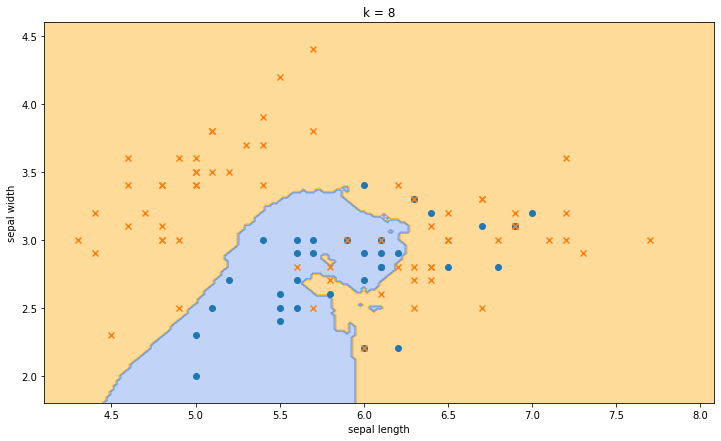

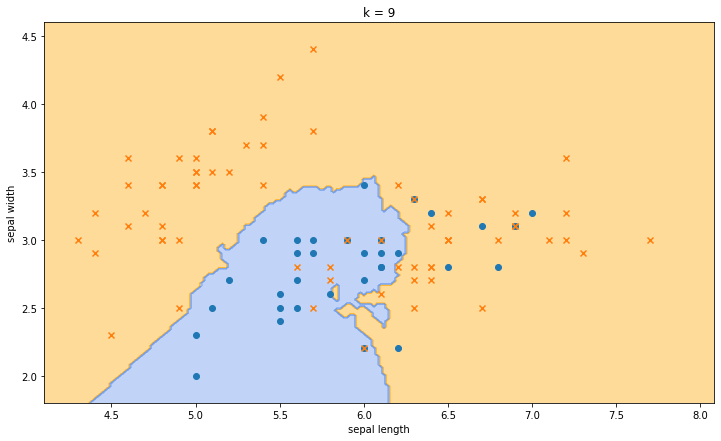

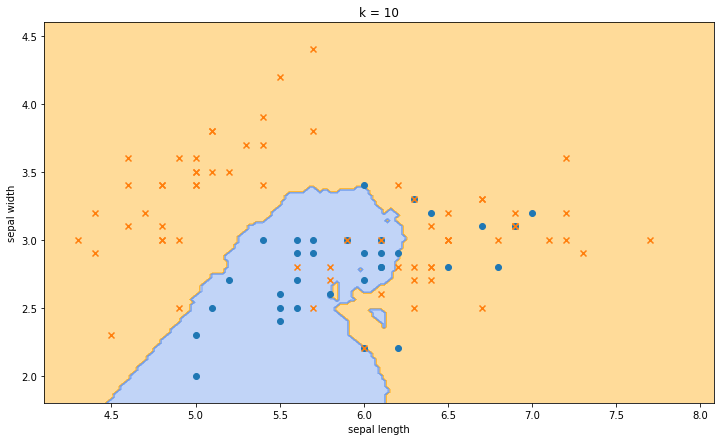

In [ ]:
from sklearn import neighbors

for k in np.arange(1, 11):
  knn_classifier = neighbors.KNeighborsClassifier(k)
  knn_classifier.fit(X_train[:,:2], y_train)
  knn_decision_surface(X, y, knn_classifier, k)

As you can see, the shape of the decision surface is quite crazy for a small value of $k$, whereas it becomes smoother and smoother when we increse $k$, but several data points are misclassified. What is going on? Let us evaluate the classifiers with the test set

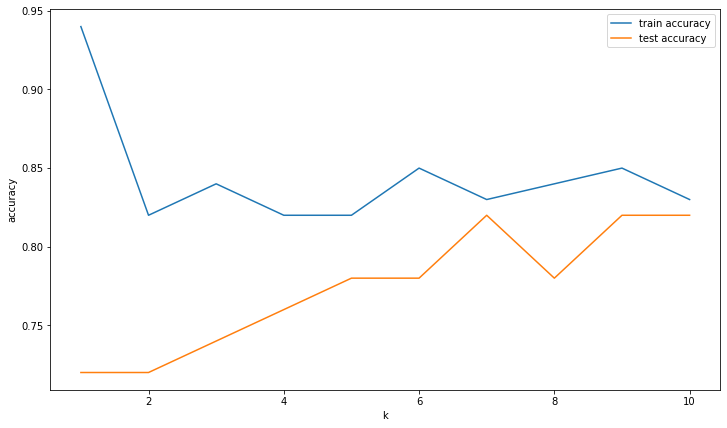

In [ ]:
parameters = np.arange(1, 11)
train_accuracy = []
test_accuracy = []

for k in parameters:
  knn_classifier = neighbors.KNeighborsClassifier(k)
  knn_classifier.fit(X_train[:,:2], y_train)

  y_hat = knn_classifier.predict(X_train)
  accuracy = sum(y_hat == y_train) / len(y_train)
  train_accuracy.append(accuracy)

  y_hat = knn_classifier.predict(X_test)
  accuracy = sum(y_hat == y_test) / len(y_test)
  test_accuracy.append(accuracy)


plt.figure(figsize=(12, 7))
plt.plot(parameters, train_accuracy, label='train accuracy')
plt.plot(parameters, test_accuracy, label='test accuracy')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.legend()
plt.show()

We have a bias-variance trade-off once again. With a small $k$, the model overfits the train set (small training error, but large test error) and incurs in a large variance. With a greater $k$, the train accuracy decresases while the test accuracy increases. However, the model struggles to correctly classify all the samples, thus there is supposedly some bias.

# Homeworks

### Forward Feature Selection

1) Implement the Forward Feature Selection method on the same classification task we considered above with the Backward version. Do you expect any change in hte results?

2) Use the cross-validation to evaluate the features instead of a validation set. Why cross-validation might be preferable in this case?

### k-Nearest Neighbors from Scratch

Implement the k-NN classifier from scratch instead of relying on the sklearn off-the-shelf implementation.

Hint: a brute-force strategy to search for the k-nearest neighbors is definitely sufficient for the classification task above.

### Principal Components Analysis for Compression

PCA can be seen as a compression method. Try to reconstruct the original dataset $X$ from the transformed dataset $T_{1,2}$ and the weights $W_{1,2}$. Do the same with $T_{3,4}$ and $W_{3,4}$. Which one works better? In which case we could perfectly reconstruct the original dataset?